## EXPERIMENT 1: MagFace

In [1]:
## Load libraries

import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import sys
sns.set(style="white")
%matplotlib inline
sys.path.append('../../utils')
from Model_utils.Model_funcs import *
from Result_metric_utils.result_metrics import *
from Data_proc_utils.Data_proc_funcs import *
from DET_utils.DET_plots import *
from DET_utils.DET import *
from Plotting_stats_utils.plotting_threshold import *
from Plotting_stats_utils.stats_tables import *
from IPython import embed


In [2]:
# Save figures
from matplotlib import pyplot as plt
save_fig_path = '../../figures/mag_2_1/'

### MagFace Results

This notebook loads the feature vectors from MagFace and run them through the results metrics:
FNIR, FPIR, FND, FPD, and GARBE

# Load data

In [3]:
feature_list_children = '../../data/data_full/feature_vectors/magface_feature_vectors/2.1/feature_vectors_from_children_filtered_bibel_FINAL_INFERENCE_finetuning_ex_2_1.list'
feature_list_adults = '../../data/data_full/feature_vectors/magface_feature_vectors/2.1/feature_vectors_from_adults_bibel_cropped_retina_all_finetuning_ex_2_1.list'

def load_and_compute_similarity(feature_list, dtype=np.float32):
    # Load data
    image_names, ids, num_ids, norm_feats = load_magface_vectors(feature_list)

    # Convert dtype to reduce memory usage
    norm_feats = norm_feats.astype(dtype)

    # Compute similarity matrix incrementally if possible
    sim_mat = np.dot(norm_feats, norm_feats.T)

    return image_names, ids, num_ids, sim_mat


In [4]:
# Load and compute for children
image_names_c, ids_c, num_ids_c, sim_mat_c = load_and_compute_similarity(feature_list_children)


/data/data_full/children_filtered_bibel_FINAL_INFERENCE/Indian_89/Indian_89_5.png
/data/data_full/children_filtered_bibel_FINAL_INFERENCE/Indian_89/Indian_89_1.png
/data/data_full/children_filtered_bibel_FINAL_INFERENCE/Indian_89/Indian_89_2.png
/data/data_full/children_filtered_bibel_FINAL_INFERENCE/Indian_m.04n3v0_/m.04n3v0__0002.jpg
/data/data_full/children_filtered_bibel_FINAL_INFERENCE/Asian_270/Asian_270_1.png
/data/data_full/children_filtered_bibel_FINAL_INFERENCE/Asian_270/Asian_270_3.png
/data/data_full/children_filtered_bibel_FINAL_INFERENCE/Asian_270/Asian_270_2.png
/data/data_full/children_filtered_bibel_FINAL_INFERENCE/Asian_344/Asian_344_19.png
/data/data_full/children_filtered_bibel_FINAL_INFERENCE/Asian_344/Asian_344_21.png
/data/data_full/children_filtered_bibel_FINAL_INFERENCE/Caucasian_167/Caucasian_167_26.png
/data/data_full/children_filtered_bibel_FINAL_INFERENCE/Caucasian_167/Caucasian_167_38.png
/data/data_full/children_filtered_bibel_FINAL_INFERENCE/Caucasian_16

In [5]:

# Load and compute for adults
image_names_a, ids_a, num_ids_a, sim_mat_a = load_and_compute_similarity(feature_list_adults)


/data/data_full/adults_filtered_bibel_cropped_resized_retina/Indian_m.02nrz2/m.02nrz2_0003.jpg
/data/data_full/adults_filtered_bibel_cropped_resized_retina/Indian_m.02nrz2/m.02nrz2_0001.jpg
/data/data_full/adults_filtered_bibel_cropped_resized_retina/Indian_m.02nrz2/m.02nrz2_0004.jpg
/data/data_full/adults_filtered_bibel_cropped_resized_retina/Indian_m.01241v/m.01241v_0002.jpg
/data/data_full/adults_filtered_bibel_cropped_resized_retina/African_m.05zn751/m.05zn751_0001.jpg
/data/data_full/adults_filtered_bibel_cropped_resized_retina/African_m.05zn751/m.05zn751_0002.jpg
/data/data_full/adults_filtered_bibel_cropped_resized_retina/African_m.05zn751/m.05zn751_0004.jpg
/data/data_full/adults_filtered_bibel_cropped_resized_retina/Indian_m.04n3v0_/m.04n3v0__0001.jpg
/data/data_full/adults_filtered_bibel_cropped_resized_retina/Indian_m.0kvkdqp/m.0kvkdqp_0001.jpg
/data/data_full/adults_filtered_bibel_cropped_resized_retina/Indian_m.0kvkdqp/m.0kvkdqp_0004.jpg
/data/data_full/adults_filtered_bib

In [6]:


# Dataframes with info, removes names not in magface results
children_all = pd.read_csv('../../data/image_info_csvs/final_filtered_children_df_BIBEL.csv')
children_all = children_all[children_all.image_name.isin(image_names_c)]

adults_all_org = pd.read_csv('../../data/image_info_csvs/final_filtered_adults_df_BIBEL.csv')
adults_all = adults_all_org[adults_all_org.image_name.isin(image_names_a)]

# Find the threshold

In [7]:
random_states = [1,2]
percentiles = np.arange(0.0, 1.0, 0.03).tolist()
df_all_threshold_x = compute_metrics_ex_1_1(random_states, percentiles, children_all, adults_all, image_names_c, image_names_a, sim_mat_c, sim_mat_a, num_ids_c, num_ids_a, ids_c, ids_a, balance_child_data, balance_adults_data_enrolled, compute_fnir, compute_fpir, GARBE)


FPD result:  0.0
FND result:  0.20347132237604856
GARBE result, GARBE close to 1 means more unfair:  0.15260349178203642
Done for random_state: 1, percentile: 0.0
FPD result:  0.0
FND result:  0.2914828313830808
GARBE result, GARBE close to 1 means more unfair:  0.21861212353731058
Done for random_state: 1, percentile: 0.03
FPD result:  0.0
FND result:  0.369154378573578
GARBE result, GARBE close to 1 means more unfair:  0.2768657839301835
Done for random_state: 1, percentile: 0.06
FPD result:  0.0
FND result:  0.3416236850540549
GARBE result, GARBE close to 1 means more unfair:  0.2562177637905412
Done for random_state: 1, percentile: 0.09
FPD result:  0.0
FND result:  0.3320904168132708
GARBE result, GARBE close to 1 means more unfair:  0.2490678126099531
Done for random_state: 1, percentile: 0.12
FPD result:  0.0
FND result:  0.34865419058408065
GARBE result, GARBE close to 1 means more unfair:  0.26149064293806046
Done for random_state: 1, percentile: 0.15
FPD result:  0.0
FND resu

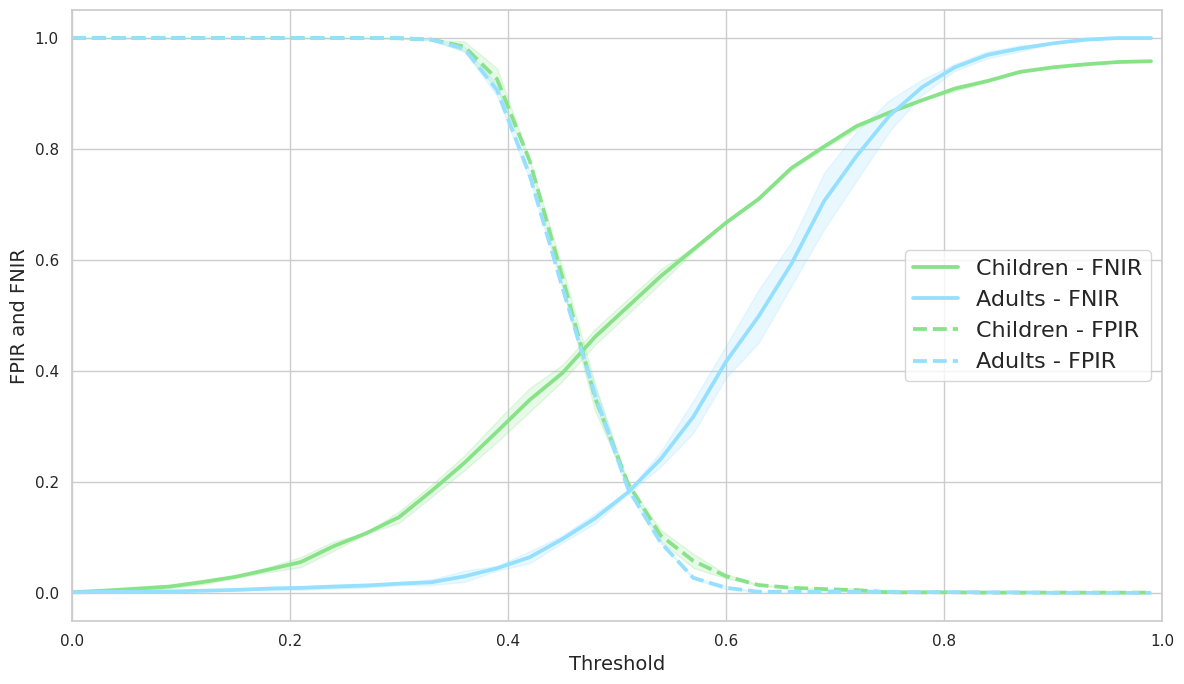

In [8]:

plot_threshold_metrics_ex_1_1_together_w_conf(df_all_threshold_x,  'MagFace ex. 2.1', save_fig_path)


# Stats - 10 experiments

In [9]:

random_states = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

df_all_results, sim_mat_dict_all_magface_ex1_1 = evaluate_metrics_ex_1_1(
    random_states, children_all, adults_all, image_names_c, image_names_a,
    sim_mat_c, sim_mat_a, num_ids_c, num_ids_a, ids_c, ids_a, balance_child_data,
    balance_adults_data_enrolled, compute_fnir, compute_fpir, GARBE, remove_ones, df_all_threshold_x[df_all_threshold_x.FNIR_c <0.05].Threshold.max()
)


FPD result:  0.0
FND result:  0.26105030674846624
GARBE result, GARBE close to 1 means more unfair:  0.1957877300613497
done
FPD result:  0.0
FND result:  0.24344398600084885
GARBE result, GARBE close to 1 means more unfair:  0.18258298950063664
done
FPD result:  0.0
FND result:  0.3227786274606542
GARBE result, GARBE close to 1 means more unfair:  0.24208397059549067
done
FPD result:  0.0
FND result:  0.2416465725111953
GARBE result, GARBE close to 1 means more unfair:  0.18123492938339647
done
FPD result:  0.0
FND result:  0.2662708330252436
GARBE result, GARBE close to 1 means more unfair:  0.1997031247689327
done
FPD result:  0.0
FND result:  0.268464326512192
GARBE result, GARBE close to 1 means more unfair:  0.201348244884144
done
FPD result:  0.0
FND result:  0.28322426008389046
GARBE result, GARBE close to 1 means more unfair:  0.21241819506291784
done
FPD result:  0.0
FND result:  0.38499313549477243
GARBE result, GARBE close to 1 means more unfair:  0.2887448516210793
done
FP

In [31]:
# Generate the LaTeX table
latex_table = generate_latex_table(df_all_results.applymap(lambda x: f"{x:.3f}").drop(columns='Iteration'))
print(latex_table)


\begin{table}
\caption{Descriptive Statistics} 
\label{table:descriptive_stats} 
\begin{tabular}{ccccccccc} 
\toprule
\textbf{{Iter.}} & $FNIR_c$ & $FNIR_a$ & $FPIR_c$ & $FPIR_a$ & $FPD$ & $FND$ & $GARBE$ & $T$ \\
\midrule
\textbf{0} & 0.032 & 0.010 & 1.000 & 1.000 & 0.000 & 0.261 & 0.196 & 0.180 \\
\textbf{1} & 0.046 & 0.016 & 1.000 & 1.000 & 0.000 & 0.243 & 0.183 & 0.180 \\
\textbf{2} & 0.037 & 0.008 & 1.000 & 1.000 & 0.000 & 0.323 & 0.242 & 0.180 \\
\textbf{3} & 0.040 & 0.014 & 1.000 & 1.000 & 0.000 & 0.242 & 0.181 & 0.180 \\
\textbf{4} & 0.044 & 0.013 & 1.000 & 1.000 & 0.000 & 0.266 & 0.200 & 0.180 \\
\textbf{5} & 0.046 & 0.014 & 1.000 & 1.000 & 0.000 & 0.268 & 0.201 & 0.180 \\
\textbf{6} & 0.040 & 0.011 & 1.000 & 1.000 & 0.000 & 0.283 & 0.212 & 0.180 \\
\textbf{7} & 0.059 & 0.008 & 1.000 & 1.000 & 0.000 & 0.385 & 0.289 & 0.180 \\
\textbf{8} & 0.045 & 0.011 & 1.000 & 1.000 & 0.000 & 0.306 & 0.230 & 0.180 \\
\textbf{9} & 0.047 & 0.006 & 1.000 & 1.000 & 0.000 & 0.393 & 0.295 & 0.180 

/tmp/ipykernel_9991/3719310588.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  latex_table = generate_latex_table(df_all_results.applymap(lambda x: f"{x:.3f}").drop(columns='Iteration'))


In [32]:
latex_table = generate_latex_table(df_all_results.describe().applymap(lambda x: f"{x:.3f}").drop(columns='Iteration'))
print(latex_table)

\begin{table}
\caption{Descriptive Statistics} 
\label{table:descriptive_stats} 
\begin{tabular}{ccccccccc} 
\toprule
\textbf{{Iter.}} & $FNIR_c$ & $FNIR_a$ & $FPIR_c$ & $FPIR_a$ & $FPD$ & $FND$ & $GARBE$ & $T$ \\
\midrule
\textbf{count} & 10.000 & 10.000 & 10.000 & 10.000 & 10.000 & 10.000 & 10.000 & 10.000 \\
\textbf{mean} & 0.044 & 0.011 & 1.000 & 1.000 & 0.000 & 0.297 & 0.223 & 0.180 \\
\textbf{std} & 0.007 & 0.003 & 0.000 & 0.000 & 0.000 & 0.055 & 0.041 & 0.000 \\
\textbf{min} & 0.032 & 0.006 & 1.000 & 1.000 & 0.000 & 0.242 & 0.181 & 0.180 \\
\textbf{25%} & 0.040 & 0.009 & 1.000 & 1.000 & 0.000 & 0.262 & 0.197 & 0.180 \\
\textbf{50%} & 0.045 & 0.011 & 1.000 & 1.000 & 0.000 & 0.276 & 0.207 & 0.180 \\
\textbf{75%} & 0.046 & 0.014 & 1.000 & 1.000 & 0.000 & 0.319 & 0.239 & 0.180 \\
\textbf{max} & 0.059 & 0.016 & 1.000 & 1.000 & 0.000 & 0.393 & 0.295 & 0.180 \\
\bottomrule
\end{tabular} 
\end{table}



/tmp/ipykernel_9991/2945641856.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  latex_table = generate_latex_table(df_all_results.describe().applymap(lambda x: f"{x:.3f}").drop(columns='Iteration'))


In [33]:
df_all_results.to_csv('df_all_results_mag_2_1.csv', index=False)


# Stats

In [34]:

import scipy.stats as stats
from scipy.stats import describe, gaussian_kde

t_statistic, p_value = stats.ttest_rel(df_all_results['FNIR_c'], df_all_results['FNIR_a'])

# Output the results
print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

T-statistic: 12.491156092399843
P-value: 5.467312425171558e-07


# Gemmer simscores

In [35]:
df_all_results.to_csv('results_10_experiment_2_1_magface.csv')

In [36]:
# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10
# List to hold all the arrays
sim_mat_c_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(11, 21):
    key = f'sim_mat_c_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_c_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

# Concatenate all arrays into one big array
sim_mat_c_enrolled_iterations_all = np.concatenate(sim_mat_c_enrolled_iterations)
sim_mat_c_enrolled_iterations_all = pd.DataFrame(sim_mat_c_enrolled_iterations_all)
sim_mat_c_enrolled_iterations_all.to_csv('sim_mat_c_enrolled_iterations_all_2_1_mag.csv', index=False)
# Print the big array
print(len(sim_mat_c_enrolled_iterations_all))



# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10

# List to hold all the arrays
sim_mat_a_enrolled_iterations = []

# Loop to access each array and append it to the list
# for i in range(1, 11):
for i in range(11, 21):
    key = f'sim_mat_a_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_a_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

# Concatenate all arrays into one big array
sim_mat_a_enrolled_iterations_all = np.concatenate(sim_mat_a_enrolled_iterations)
sim_mat_a_enrolled_iterations_all = pd.DataFrame(sim_mat_a_enrolled_iterations_all)
sim_mat_a_enrolled_iterations_all.to_csv('sim_mat_a_enrolled_iterations_all_2_1_mag.csv', index=False)


# Print the big array
print(len(sim_mat_a_enrolled_iterations_all))


124748
41822


In [37]:
# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10

# List to hold all the arrays
sim_mat_c_non_enrolled_iterations = []

# Loop to access each array and append it to the list
# for i in range(1, 11):
for i in range(11, 21):
    key = f'sim_mat_c_non_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_c_non_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

sim_mat_c_non_enrolled_iterations_all = np.concatenate(sim_mat_c_non_enrolled_iterations)
sim_mat_c_non_enrolled_iterations_all = pd.DataFrame(sim_mat_c_non_enrolled_iterations_all)
sim_mat_c_non_enrolled_iterations_all.to_csv('sim_mat_c_non_enrolled_iterations_all_2_1_mag.csv', index=False)
# Print the big array
print(len(sim_mat_c_non_enrolled_iterations_all))


# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10

# List to hold all the arrays
sim_mat_a_non_enrolled_iterations = []

# Loop to access each array and append it to the list
# for i in range(1, 11):
for i in range(11, 21):
    key = f'sim_mat_a_non_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_a_non_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

sim_mat_a_non_enrolled_iterations_all = np.concatenate(sim_mat_a_non_enrolled_iterations)
sim_mat_a_non_enrolled_iterations_all = pd.DataFrame(sim_mat_a_non_enrolled_iterations_all)
sim_mat_a_non_enrolled_iterations_all.to_csv('sim_mat_a_non_enrolled_iterations_all_2_1_mag.csv', index=False)

# Print the big array
print(len(sim_mat_a_non_enrolled_iterations_all))


32872996
32603172


# Loading pre-saved stuff

In [38]:
sim_mat_c_enrolled_iterations_all = (pd.read_csv('sim_mat_c_enrolled_iterations_all_2_1_mag.csv')).values.flatten()
sim_mat_a_enrolled_iterations_all = (pd.read_csv('sim_mat_a_enrolled_iterations_all_2_1_mag.csv')).values.flatten()
sim_mat_c_non_enrolled_iterations_all = (pd.read_csv('sim_mat_c_non_enrolled_iterations_all_2_1_mag.csv')).values.flatten()
sim_mat_a_non_enrolled_iterations_all = (pd.read_csv('sim_mat_a_non_enrolled_iterations_all_2_1_mag.csv')).values.flatten()


In [39]:
from scipy.stats import describe, gaussian_kde
import math

def descriptive_statistics(mated_scores, nonmated_scores):
    stats_labels = ["Observations", "Minimum", "Maximum", "Mean", "St. Dev.", "Skewness", "Ex. Kurtosis"]
    mated_stats = describe(mated_scores)
    mated_stats = [mated_stats.nobs, mated_stats.minmax[0], mated_stats.minmax[1], mated_stats.mean, math.sqrt(mated_stats.variance), mated_stats.skewness, mated_stats.kurtosis]
    nonmated_stats = describe(nonmated_scores)
    nonmated_stats = [nonmated_stats.nobs, nonmated_stats.minmax[0], nonmated_stats.minmax[1], nonmated_stats.mean, math.sqrt(nonmated_stats.variance), nonmated_stats.skewness, nonmated_stats.kurtosis]

    stats_system_df = pd.DataFrame(np.array([stats_labels, mated_stats, nonmated_stats]).T, columns=["Statistic", "Mated", "Non-mated"])
    stats_system_df = stats_system_df.astype({"Statistic": str, "Mated": float, "Non-mated": float})
    return stats_system_df

In [40]:
mated_scores1 = sim_mat_a_enrolled_iterations_all
nonmated_scores1 = sim_mat_a_non_enrolled_iterations_all
scores_type1 = "similarity"
stats_system1_df = descriptive_statistics(mated_scores1, nonmated_scores1)
display(stats_system1_df)

,Statistic,Mated,Non-mated
0,Observations,41822.000000,3.260317e+07
1,Minimum,-0.069577,-4.553997e-01
2,Maximum,0.967829,9.325352e-01
3,Mean,0.648337,8.722053e-02
4,St. Dev.,0.130688,1.024774e-01
5,Skewness,-0.865896,1.680885e-01
6,Ex. Kurtosis,2.414170,1.920130e-01


In [41]:
mated_scores2 = sim_mat_c_enrolled_iterations_all
nonmated_scores2 = sim_mat_c_non_enrolled_iterations_all
scores_type2 = "similarity"
stats_system2_df = descriptive_statistics(mated_scores2, nonmated_scores2)
display(stats_system2_df)

,Statistic,Mated,Non-mated
0,Observations,124748.000000,3.287300e+07
1,Minimum,-0.097652,-4.763693e-01
2,Maximum,0.997552,9.999374e-01
3,Mean,0.524316,5.045138e-02
4,St. Dev.,0.179281,1.150694e-01
5,Skewness,-0.142249,1.386887e-01
6,Ex. Kurtosis,-0.267492,2.726840e-02


In [42]:
mated_colour = "green"
mated_label = "Mated scores"
nonmated_colour = "red"
nonmated_label = "Non-mated scores"

figure_size = (12,6)
alpha_shade = 0.25
alpha_fill = 1.0
linewidth = 2
legend_loc = "upper left"
legend_anchor = (1.0, 1.02)
legend_cols = 1
legend_fontsize = 16
label_fontsize = 20

threshold_colour = "black"
threshold_style = "--"
round_digits = 5
sns.set(style="white", palette="muted", color_codes=True)
plt.rc("axes", axisbelow=True)

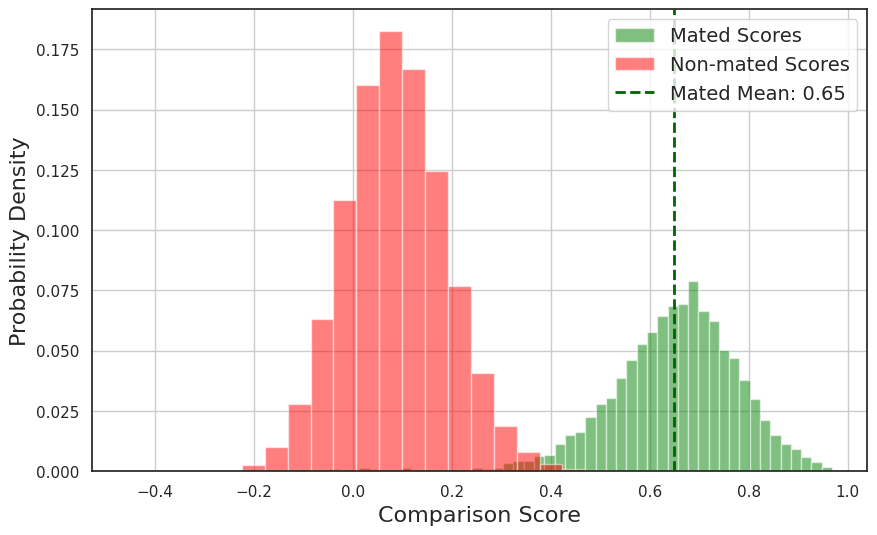

In [52]:

plot_histogram(mated_scores1, nonmated_scores1, normalise=True, title = 'Adults - MagFace ex. 2.1 ',save_fig_path=save_fig_path, gem_som = 'A1')


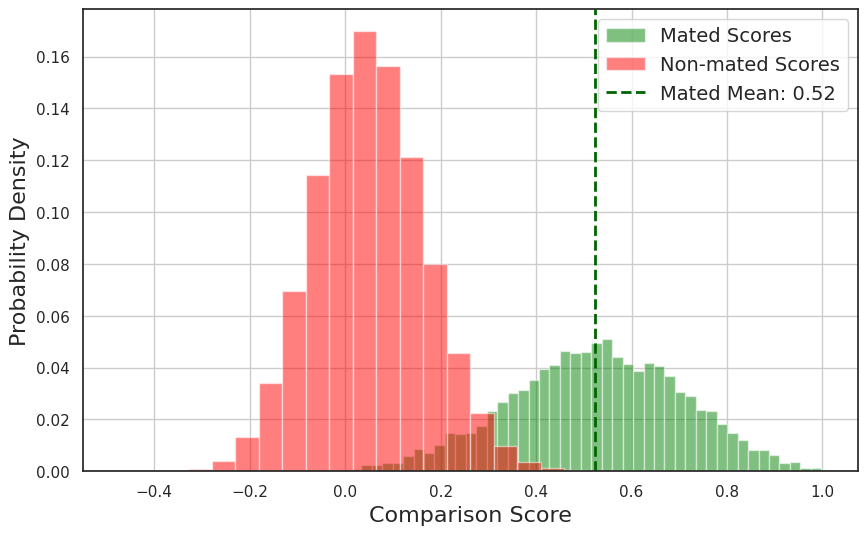

In [51]:
plot_histogram(mated_scores2, nonmated_scores2, normalise=True, title = 'Children - MagFace ex. 2.1 ',save_fig_path=save_fig_path, gem_som='C1')


# DET curves

In [45]:
d_prime_system1 = d_prime(mated_scores1, nonmated_scores1)
print("d' child =", round(d_prime_system1, round_digits))

d_prime_system2 = d_prime(mated_scores2, nonmated_scores2)
print("d' adult =", round(d_prime_system2, round_digits))


d' child = 4.77822
d' adult = 3.14576


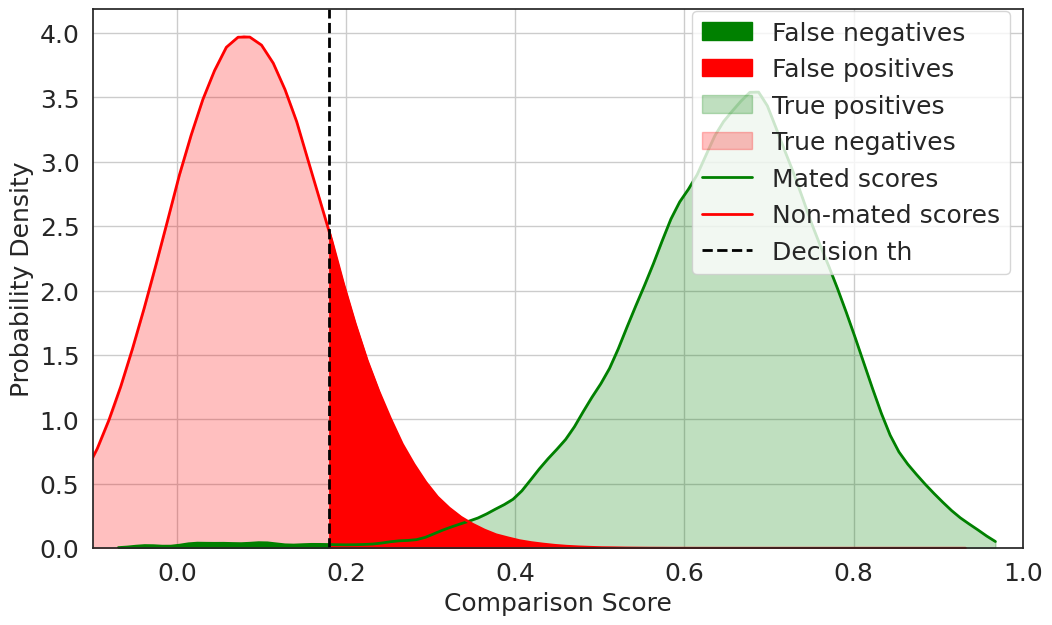

In [50]:
from DET_utils.DET_plots import *
threshold1 = df_all_threshold_x[df_all_threshold_x.FNIR_c <0.05].Threshold.max()
kde_with_threshold(mated_scores1, nonmated_scores1, scores_type1, threshold1, save_fig_path=save_fig_path, title='A2')


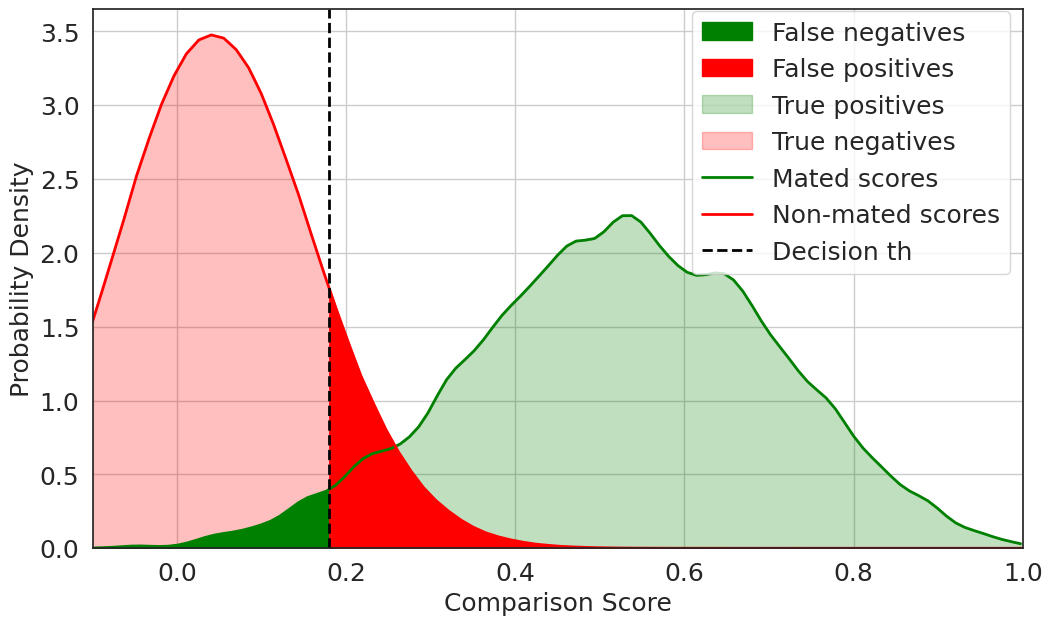

In [47]:
threshold2 = df_all_threshold_x[df_all_threshold_x.FNIR_c <0.05].Threshold.max()
kde_with_threshold(mated_scores2, nonmated_scores2, scores_type2, threshold2, save_fig_path=save_fig_path, title='C2')

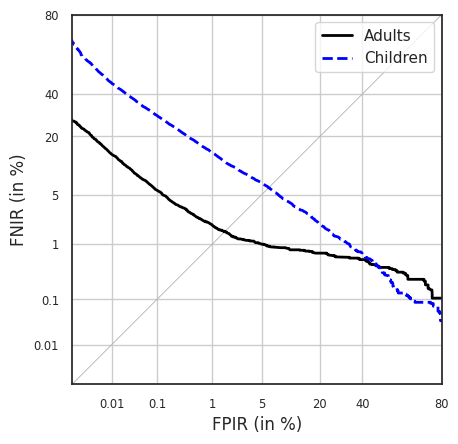

In [48]:
def DET_plotting_1_1(mated_scores1, mated_scores2,nonmated_scores1, nonmated_scores2, score_type= "similarity",title = 'Adults vs Children - MagFace ex. 2.2', save_fig_path= 'save_fig_path'):
    figure_size = (12,7)
    alpha_shade = 0.25
    alpha_fill = 1.0
    linewidth = 2
    legend_loc = "upper left"
    legend_anchor = (1.0, 1.02)
    legend_cols = 1
    legend_fontsize = 18
    label_fontsize = 18
    tick_fontsize = 18
    system_name1 = 'Adults'
    system_name2 = 'Children'

    det = DET(biometric_evaluation_type='identification', abbreviate_axes=True, plot_eer_line=True)#, plot_title=title)
    det.x_limits = np.array([1e-5, .8])
    det.y_limits = np.array([1e-5, .8])
    det.x_ticks = np.array([1e-4, 1e-3, 1e-2, 5e-2, 20e-2, 40e-2, 80e-2])
    det.x_ticklabels = np.array(['0.01','0.1', '1', '5', '20', '40', '80'])
    det.y_ticks = np.array([1e-4, 1e-3, 1e-2, 5e-2, 20e-2, 40e-2, 80e-2])
    det.y_ticklabels = np.array(['0.01','0.1', '1', '5', '20', '40', '80'])
    det.create_figure()
    det.plot(tar=adjust_scores_for_DET(mated_scores1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label=system_name1)
    det.plot(tar=adjust_scores_for_DET(mated_scores2, scores_type2), non=adjust_scores_for_DET(nonmated_scores2, scores_type2), label=system_name2)
    det.legend_on(loc="upper right")
    det.show()

DET_plotting_1_1(mated_scores1, mated_scores2,nonmated_scores1, nonmated_scores2, 'Adults vs Children - MagFace ex. 2.1', save_fig_path= save_fig_path)
